In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('data.csv')
data

,steps_during_morning,steps_during_afternoon,steps_during_evening,steps_during_bedtime,steps_during_morning_ndays_mean,steps_during_morning_ndays_stdev,steps_during_morning_ndays_gradient,steps_during_afternoon_ndays_mean,steps_during_afternoon_ndays_stdev,steps_during_afternoon_ndays_gradient,steps_during_evening_ndays_mean,steps_during_evening_ndays_stdev,steps_during_evening_ndays_gradient,steps_during_bedtime_ndays_mean,steps_during_bedtime_ndays_stdev,steps_during_bedtime_ndays_gradient,sleep_length_ndays_mean,sleep_length_ndays_stdev,sleep_length_ndays_gradient,sleep_efficiency_ndays_mean,sleep_efficiency_ndays_stdev,sleep_efficiency_ndays_gradient,sleep_onset_dev_ndays_mean,sleep_onset_dev_ndays_stdev,sleep_onset_dev_ndays_gradient,sleep_offset_dev_ndays_mean,sleep_offset_dev_ndays_stdev,sleep_offset_dev_ndays_gradient,sleep_counts_ndays_mean,sleep_counts_ndays_stdev,sleep_counts_ndays_gradient,late_sleep_offset_ndays_mean,late_sleep_offset_ndays_stdev,late_sleep_offset_ndays_gradient,midday_sleep_minutes_ndays_mean,midday_sleep_minutes_ndays_stdev,midday_sleep_minutes_ndays_gradient,sleep_length,sleep_efficiency,sleep_onset_dev,...,late_sleep_offset,midday_sleep_minutes,resting_heartrate_ndays_mean,resting_heartrate_ndays_stdev,resting_heartrate_ndays_gradient,resting_heartrate,light_during_morning_ndays_mean,light_during_morning_ndays_gradient,light_during_morning_ndays_stdev,light_during_afternoon_ndays_mean,light_during_afternoon_ndays_stdev,light_during_afternoon_ndays_gradient,light_during_evening_ndays_mean,light_during_evening_ndays_stdev,light_during_evening_ndays_gradient,light_during_bedtime_ndays_mean,light_during_bedtime_ndays_stdev,light_during_bedtime_ndays_gradient,light_during_morning,light_during_afternoon,light_during_evening,light_during_bedtime,amplitude_ndays_mean,amplitude_ndays_stdev,amplitude_ndays_gradient,acrophase_ndays_mean,acrophase_ndays_stdev,acrophase_ndays_gradient,mesor_ndays_mean,mesor_ndays_gradient,mesor_ndays_stdev,goodness_of_fit_ndays_mean,goodness_of_fit_ndays_stdev,goodness_of_fit_ndays_gradient,amplitude,mesor,acrophase,goodness_of_fit,timestamp,patient_id
0,46.0,4271.0,3886.0,238.0,2407.000,1517.620,1359.000,6049.67,4045.350,4024.0000,899.500,170.413,-120.500000,341.500,9.19239,6.500000,4.98333,4.73762,-6.700000,95.0000,1.41421,2.000000e+00,5.00000,4.242640,6.000000e+00,6.00000,5.65685,8.000000,1.00000,0.000000,0.00,8.540620,8.583970,12.139600,0.00000,0.0000,0.000000,7.68333,87.0,2.0,...,2.51354,0.0,77.00670,5.558290,-0.550000,89.47,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261,0.050250,0.000000,0.115626,0.197581,0.065966,0.042983,12.2952,2.077860,0.884489,14.86160,1.053040,-0.471291,72.5112,0.463240,1.809390,0.468774,0.092405,0.028774,16.55450,75.8027,13.51340,0.636873,2015-08-30,0
1,8975.0,4294.0,1209.0,238.0,7144.570,2499.000,650.500,7533.57,3439.870,-463.6070,5107.290,2324.120,-327.143000,434.000,443.43200,0.607143,9.60000,1.72359,0.055956,92.5714,3.25869,7.500000e-01,5.42857,0.534522,-1.428570e-01,4.14286,1.06904,0.142857,1.42857,0.786796,0.25,0.145238,0.206315,0.001190,0.00000,0.0000,0.000000,8.21667,95.0,4.0,...,0.00000,0.0,69.79140,10.489200,4.360360,84.21,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261,0.050250,0.000000,0.115626,0.197581,0.065966,0.042983,16.2891,0.886982,-0.031143,13.77050,0.333792,-0.009600,71.1302,0.493779,2.250650,0.615644,0.048942,-0.012300,13.46240,78.3996,13.83120,0.473510,2015-10-28,0
2,204.0,428.0,835.0,617.0,3088.710,1675.700,524.071,4489.14,2921.570,-81.9286,316.667,494.056,117.964000,166.667,192.20800,-7.214290,12.16390,5.31505,-1.323330,94.5833,1.74404,4.714290e-01,5.16667,3.600930,-1.228570e+00,3.83333,3.76386,-0.885714,1.83333,1.169050,-0.20,2.470140,1.790740,0.686190,23.33330,36.1534,-0.171429,18.45000,93.0,6.0,...,5.06042,274.0,67.85070,19.986300,4.512860,59.87,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261

In [3]:
# timestamp를 datetime 타입으로 변환 (안 돼 있다면)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 정렬
data = data.sort_values(by=['patient_id', 'timestamp']).reset_index(drop=True)
print(data)

       steps_during_morning  steps_during_afternoon  ...  timestamp  patient_id
0                    1234.0                  6754.0  ... 2015-04-23           0
1                    4800.0                  6657.0  ... 2015-04-24           0
2                    4308.0                  8619.0  ... 2015-04-25           0
3                    5588.0                  6085.0  ... 2015-04-26           0
4                    7171.0                 13155.0  ... 2015-04-30           0
...                     ...                     ...  ...        ...         ...
58831                5226.0                  8911.0  ... 2019-05-08         224
58832                5757.0                  5435.0  ... 2019-05-09         224
58833                5807.0                  6950.0  ... 2019-05-10         224
58834                5870.0                 12514.0  ... 2019-05-14         224
58835                4711.0                  1921.0  ... 2019-05-17         224

[58836 rows x 82 columns]


In [4]:
from sklearn.preprocessing import StandardScaler

# 수치형 컬럼만 선택
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'patient_id']

# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 정규화된 데이터 저장
data.to_csv('normalized_data.csv', index=False)

print("정규화가 완료되었습니다.")
print("\n처음 5개 행:")
print(data.head())

정규화가 완료되었습니다.

처음 5개 행:
   steps_during_morning  steps_during_afternoon  ...  timestamp  patient_id
0             -0.285944                0.857065  ... 2015-04-23           0
1              1.359486                0.826138  ... 2015-04-24           0
2              1.132467                1.451692  ... 2015-04-25           0
3              1.723087                0.643765  ... 2015-04-26           0
4              2.453517                2.897925  ... 2015-04-30           0

[5 rows x 82 columns]


In [5]:
def compute_sleep_quality_score(row):
    efficiency = row["sleep_efficiency"]
    length = row["sleep_length"]
    counts = row["sleep_counts"]
    onset_dev = row["sleep_onset_dev"]

    score = (0.35 * efficiency + 0.2 * length - 0.2 * counts - 0.25 * onset_dev)
    return round(score * 100, 2)
data['sleep_quality_score'] = data.apply(compute_sleep_quality_score, axis=1)

# 로그를 씌우기 위해 음수 방지: 모든 값에 offset을 더함
#data['sleep_quality_score'] = np.log(data['sleep_quality_score'])

print(data['sleep_quality_score'].describe())

count    58836.000000
mean         0.000465
std         52.460473
min       -592.130000
25%        -14.490000
50%         16.965000
75%         25.340000
max        184.350000
Name: sleep_quality_score, dtype: float64


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_score = scaler.fit_transform(data[['sleep_quality_score']])

data['normalized_score'] = normalized_score*100

data['normalized_score'].describe()

count    58836.000000
mean        76.258302
std          6.756191
min          0.000000
25%         74.392129
50%         78.443102
75%         79.521688
max        100.000000
Name: normalized_score, dtype: float64

In [9]:
data = data.drop([
    'sleep_length',
    'sleep_efficiency',
    'sleep_onset_dev',
    'sleep_counts'
], axis=1)





In [8]:
# 정규화된 데이터 저장
data.to_csv('processed_data.csv', index=False)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 예시: 수면의 질을 예측할 특징(features)와 목표(target)
features = data.drop(columns=['normalized_score','sleep_quality_score', 'patient_id', 'timestamp'])
target = data['normalized_score']  # 또는 score_level로 분류 모델 만들 수도 있음


# 80% 훈련, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2, 
    random_state=42  # 결과 재현 가능하게
)

"""# 훈련, 테스트 데이터 저장
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
"""

KeyError: "['score_level'] not found in axis"

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 정의 (회귀용)
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # 회귀용 출력층
])

# 회귀에 적합한 손실함수 및 평가지표 사용
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

# 예측
y_pred = model.predict(X_test).flatten()

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")


C:\Users\82102\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5919 - loss: 0.8821 - val_accuracy: 0.6453 - val_loss: 0.7759
Epoch 2/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6617 - loss: 0.7401 - val_accuracy: 0.6581 - val_loss: 0.7576
Epoch 3/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6780 - loss: 0.7034 - val_accuracy: 0.6533 - val_loss: 0.7461
Epoch 4/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6852 - loss: 0.6889 - val_accuracy: 0.6546 - val_loss: 0.7400
Epoch 5/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6926 - loss: 0.6758 - val_accuracy: 0.6579 - val_loss: 0.7482
Epoch 6/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7020 - loss: 0.6491 - val_accuracy: 0.6553 - val_loss: 0.7527
Epoch 7/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7089 - loss: 0.6338 - val_accuracy: 0.6479 - val_loss: 0.7691
Epoch 8/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7191 - loss:

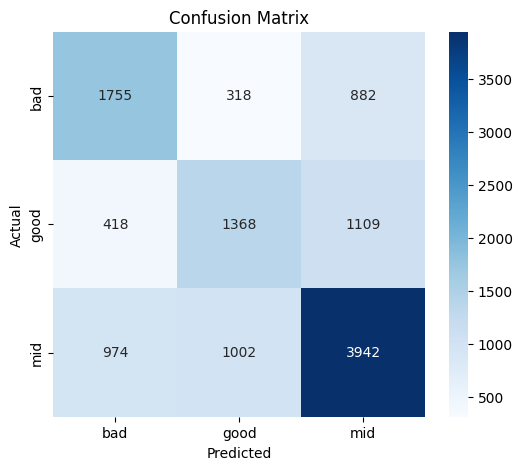


Classification Report:
              precision    recall  f1-score   support

         bad       0.56      0.59      0.58      2955
        good       0.51      0.47      0.49      2895
         mid       0.66      0.67      0.67      5918

    accuracy                           0.60     11768
   macro avg       0.58      0.58      0.58     11768
weighted avg       0.60      0.60      0.60     11768



In [11]:

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 성능 보고서
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))